# 1. Set up

## 1. Packages and requirements

In [1]:
# Major builtin libraries
import os
import gc
import cv2
# import mat
import time
import random
import typing as t
from copy import deepcopy
from collections import defaultdict

In [ ]:
# To work with Google Collab
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

In [8]:
import warnings  # If you want to disable warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
# Classic packages for data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Basic PyTorch
import torch
import torch.nn as nn
import torch.optim as optim  # Optimization algorithms
import torch.nn.functional as F
from torch.nn.modules.loss import _Loss
from torch.optim import lr_scheduler  # Dynamic learning rate adjusting
from torch.utils.data import DataLoader, Dataset  # For custom data presentation
# from torch.cuda import amp

In [4]:
# Utils
import joblib  # Pipelining and pickling (dump/load)
from tqdm import tqdm  # Progress bar for training process
from tempfile import TemporaryDirectory

# Classic ML tools
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold  # Cross-Validation

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
# ML Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from torchmetrics.classification import F1Score  # F1 metric for multiclass

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [6]:
# Torch Computer Vision tools for images processing
from torchvision.io import read_image
from torchvision.transforms.functional import to_pil_image, to_grayscale, to_tensor
from torchvision import models  # Pretrained models

In [8]:
# Albumentations is an OS library for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2
# import torchvision.transforms as T  # We can use torch augmentations instead

In [9]:
# Output text colorizing
from colorama import Back, Style

def print_highlighted(text: str, bgcolor=Back.YELLOW) -> None:
    """
    Function to print a text with colored background.
    """
    print(bgcolor + text + Style.RESET_ALL)

In [10]:
import wandb # MLOps platform to simplify and speed up the process of building ML models

In [11]:
# wandb.login() # We log in via pop-up,
# wandb.login(key=api_key)  # but you can also log in manually with function args

## 2. Configuration

In [12]:
CONFIG = {
    "seed": 2306,
    "epochs": 20,
    "image_dimension": 256,  # Depends on pretrained model used
    "model_name": "efficientnet_b0",  # Pretrained model we will use
    # "embedding_size": 512,  # Embedding output size
    "train_batch_size": 32,
    "val_batch_size": 64,
    "learning_rate": 1e-3,
    "min_lr": 1e-8,
    "min_loss_delta": 1e-5, # To stop training on plateau
    "weight_decay": 1e-6,
    "n_folds": 5,
    "n_accumulate": 1,
}

In [13]:
class Config:
    """
    Class to simplify access to Config: not dict but object with attributes
    """
    def __init__(self, config_dict):
        for key, value in config_dict.items():
            setattr(self, key, value)

In [14]:
config = Config(config_dict=CONFIG)
del CONFIG

In [15]:
# Work example
config.seed

2306

## 3. Set Seed for Reproducibility

In [16]:
def set_seed(seed=42):
    """
    Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.
    """
    np.random.seed(seed)
    torch.manual_seed(seed)

    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True  # When False, this option makes CUDA reproducible, BUT the performance might suffer

    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(seed=config.seed)

In [ ]:
# 2. Data

In [ ]:
# 1. Location

In [17]:
config.repo = 'car-brands/'  # dataset name on Kaggle
# config.repo = 'data/'  # dataset name on local device

config.root = '/kaggle/input/' + config.repo
# config.root = '../'

config.data = config.root
# config.data = config.root + 'data/'

config.train_images_path  = config.data + 'images/train'
config.test_images_path = config.data + 'images/test'
# config.train_images_path  = config.data + 'dataset/train'
# config.test_images_path = config.data + 'dataset/test'

config.train_labels  = config.data + 'train_labels.csv'
config.test_labels = config.data + 'test_labels.csv'

In [19]:
def get_file_path_by_id(file_id, dir=config.root):
    return os.path.join(dir, str(file_id) + ".jpg")

## 2. Custom Data representation

In [25]:
def apply_label_encoding(data: t.Union[pd.DataFrame, np.array],
                         encoder_name: os.path,
                         column='label', action='encode',
                         ):
    """
    One Hot encoding. We apply encoding by replacing the label column in dataframe.
    As for decoding data back, we work with vector-array (as it's most likely to
    be a prediction result)
    """
    encoder = LabelEncoder()
    if action == 'encode':
        # We transform dataframe here. Nothing returns
        data[column] = encoder.fit_transform(data[column])
        with open(f"{encoder_name}_LEncoder.pkl", "wb") as fp:
            joblib.dump(encoder, fp)
    elif action == 'decode':
        # We pass vector here. Result is a vector
        with open(f"{encoder_name}_LEncoder.pkl", "rb") as fp:
            encoder: LabelEncoder = joblib.load(fp)
        return encoder.inverse_transform(data)

In [26]:
class CustomImagesDataset(Dataset):
    """
    """
    def __init__(self, data: pd.DataFrame=None, images_path: os.path=None, labels_path:os.path=None, transform_images: A.Compose=None, encoder_name: str=None):
        """

        """
        super().__init__()
        assert (data is not None) or (labels_path is not None and images_path is not None)

        if data is None:
            data = pd.read_csv(labels_path)
            data['file_path'] = data['id'].apply(get_file_path_by_id, dir=images_path)

        self.images_paths = data['file_path'].values
        self.encoder_name = encoder_name if encoder_name else self.__hash__()  # We use hash as a unique name
        print_highlighted(f"Label Encoder saved with id `{self.encoder_name}`")
        apply_label_encoding(data=data, action='encode', encoder_name=self.encoder_name)
        self.labels = data['label'].values
#         self.indexes = data['id'].values
        self.transform_images = transform_images
        self.__set_dataset_len()

    def __set_dataset_len(self):
        self.length = self.labels.shape[0] # Number of rows

    def __len__(self):
        """
        We calculate the len in another function, so that we are able to slice.
        """
        return self.length

    def decode_labels(self, labels_vector):
        return apply_label_encoding(data=labels_vector, action='decode', encoder_name=self.encoder_name)

    def __getitem__(self, index) -> tuple[torch.Tensor, int]:
        """ Function to return item by indexing the dataset """

        if not isinstance(index, int) and isinstance(index, slice):
            # It's not an index, but slice.
            # We will return the part of data by making a copy of the dataset
            index: slice
            self = deepcopy(self)
            self.length = index.stop  # Cut the length of dataset.
            self.labels = self.labels[:self.length]
            return self
        assert self.__len__() >= index

        image = to_pil_image(read_image(self.images_paths[index]))
        if self.transform_images:
            # Albumentations requires us to convert image to Numpy Array
            image = self.transform_images(image=np.array(image))['image']

        label = self.labels[index]
        return image, label


    @property
    def classes_(self):
        return self.decode_labels(np.unique(self.labels))


## 3. Augmentations

We use Albumantations lib

In [27]:
data_transforms = {
    "train": A.Compose([
#         A.ToRGB(),
        A.Resize(config.image_dimension, config.image_dimension),
        A.ShiftScaleRotate(shift_limit=0.1,
                           scale_limit=0.15,
                           rotate_limit=30,
                           p=0.5),
        A.HueSaturationValue(
                hue_shift_limit=30,
                sat_shift_limit=30,
                val_shift_limit=30,
                p=0.5
            ),
        A.RandomBrightnessContrast(
                brightness_limit=(-0.01,0.01),
                contrast_limit=(-0.01, 0.01),
                p=0.5
            ),
        A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
                max_pixel_value=255.0,
                p=1.0
            ),
        ToTensorV2() # Advanced analogue of T.ToTensor
    ], p=1.),

    "val": A.Compose([
#         A.ToRGB(),
        A.Resize(config.image_dimension, config.image_dimension),
        A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
                max_pixel_value=255.0,
                p=1.0
            ),
        ToTensorV2()], p=1.)
}

## 4. Load the data and have a look

In [28]:
train_dataset = CustomImagesDataset(labels_path=config.train_labels, images_path=config.train_images_path, transform_images=data_transforms['train'], encoder_name='train')

In [29]:
test_dataset = CustomImagesDataset(
    labels_path=config.test_labels,
    images_path=config.test_images_path,
    transform_images=data_transforms['val'],
    encoder_name='test',
)

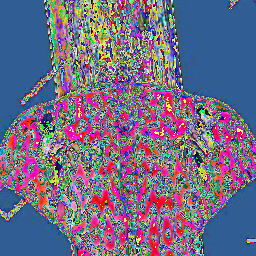

In [31]:
to_pil_image(test_dataset[60][0])

In [46]:
config.num_of_classes = len(train_dataset.classes_)
config.num_of_classes

75

Below we ensure that the test dataset doesn't contain unknown data

In [47]:
assert not bool(set(test_dataset.classes_) - set(train_dataset.classes_))

In [48]:
print(*train_dataset.classes_[:20], sep=';  ', end='...')

ADONIS;  AFRICAN GIANT SWALLOWTAIL;  AMERICAN SNOOT;  AN 88;  APPOLLO;  ATALA;  BANDED ORANGE HELICONIAN;  BANDED PEACOCK;  BECKERS WHITE;  BLACK HAIRSTREAK;  BLUE MORPHO;  BLUE SPOTTED CROW;  BROWN SIPROETA;  CABBAGE WHITE;  CAIRNS BIRDWING;  CHECQUERED SKIPPER;  CHESTNUT;  CLEOPATRA;  CLODIUS PARNASSIAN;  CLOUDED SULPHUR...

# 3. Model

## 1. Getting the pretrained model

In [51]:
def get_model(model_name='resnet18', from_path=None, pretrained=False, freeze_layers=0.0, get_embeddings=False) -> torch.nn.Module:
    got_model = False
    if from_path:
        try:
            model = torch.load(from_path)
            got_model = True
        except FileNotFoundError:
            pass
    if not got_model:
        model = getattr(models, model_name) # We use builtin function
        model = model(
        weights=('DEFAULT' if pretrained else None)
        )
        return model

    if bool(freeze_layers):
        params = list(model.parameters())
        for param in params[:int(len(params)*freeze_layers)]:
            # Freeze some layers
            param.requires_grad = False

    if get_embeddings:
        # That means remove classifyer (last layer):
        model = nn.Sequential(*list(model.children())[:-1])
    return model

In [52]:
model = get_model(
    model_name=config.model_name, 
    pretrained=True, 
    freeze_layers=0.0, 
    get_embeddings=False
)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 29.9MB/s]


In [53]:
# model

## 2. Set up the output layer

Efficient Model consists of 3 blocks (2 Sequential and one Avg Pooling between them. Let's have a look at last two layers

Last layer is classifier.

In [54]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

Let's change the number of classes (according with our task), and add a Softmax

In [55]:
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=model.classifier[1].in_features, out_features=config.num_of_classes, bias=True),
    nn.Softmax(dim=-1)
)

In [57]:
# model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

# 4. Various

## 1. Quality metrics

In [ ]:
We will use accuracy and F1 score for out classification task

In [49]:
f1_score = F1Score(task="multiclass", num_classes=config.num_of_classes, average="macro")

## 2. Device

In [58]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
f1_score = f1_score.to(device)
torch.cuda.empty_cache()

## 3. Data processing format

In [50]:
config.train_batch_size, config.val_batch_size = 64, 128

In [59]:
train_dataloader = DataLoader(train_dataset,
                              batch_size=config.train_batch_size,
                              shuffle=True,
                              num_workers=os.cpu_count(),
)

In [60]:
test_dataloader = DataLoader(test_dataset,
                              batch_size=config.val_batch_size,
                              shuffle=False,
                              num_workers=os.cpu_count(),
)

# 5. Initialize train process

## 1. Functions to plot the result

In [ ]:
def plot_two_curves(
        title: str = None,
        train_curve: list[float],
        val_curve: list[float],

):
    plt.figure(figsize=(16, 8))
    plt.title(title)
    plt.plot(train_curve, label=f'Train {title}')
    plt.plot(val_curve, label=f'Valid {title}')
    plt.legend()
    plt.grid()
    plt.show()


In [61]:
def plot_stats(
        train_loss: list[float],
        valid_loss: list[float],
        train_accuracy: list[float]=None,
        valid_accuracy: list[float]=None,
        train_f1_score: list[float]=None,
        valid_f1_score: list[float]=None,
        title: str = None
):
    plot_two_curves(
        'Loss',
        train_loss,
        valid_loss
    )

    if train_accuracy and valid_accuracy:
        plot_two_curves(
            'accuracy',
            train_accuracy,
            valid_accuracy
        )

    if train_f1_score and valid_f1_score:
        plot_two_curves(
            title='F1 score',
            train_f1_score,
            valid_f1_score
        )


## 2. Training and evaluation functions

In [62]:
def train_one_epoch(model, dataloader, optimizer, criterion, scheduler, device, epoch: str):
    model.train()

    train_loss = 0.0
    train_correct = 0.0
    train_f1 = 0.0
    n_batches = 0
    data_size = 0
    lr = scheduler.get_last_lr()

    with tqdm(dataloader, desc=f'Epoch: {epoch}', unit="batch") as tepoch:
        for images, labels in tepoch:
            n_batches += 1
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            embeddings = model(images)

            loss = criterion(embeddings, labels)
            loss.backward()
            optimizer.step()

            loss = loss.item()  # item() extracts scalar
            train_loss += loss

            _, predicted = torch.max(embeddings.data, 1)

            train_correct += (predicted == labels).sum().item()
            data_size += labels.size(0)
            train_accuracy = train_correct / data_size

            f1 = f1_score(predicted, labels).item()
            train_f1 += f1
            tepoch.set_postfix(loss=loss, acc=train_accuracy, lr=lr)

    train_loss /= n_batches
    train_f1 /= n_batches
    gc.collect()
    torch.cuda.empty_cache()

    return train_loss, train_accuracy, train_f1

In [64]:
@torch.inference_mode()
def validate_one_epoch(model, dataloader, criterion, device):
    model.eval()

    val_loss = 0.0
    val_correct = 0.0
    val_f1_score = 0.0
    data_size = 0
    n_batches = 0

    with tqdm(dataloader, desc="Validation",unit="batch") as tepoch:
        for images, labels in tepoch:
            n_batches += 1
            images = images.to(device)
            labels = labels.to(device)
            embeddings = model(images)

            loss = criterion(embeddings, labels).item()
            val_loss += loss

            _, predicted = torch.max(embeddings.data, 1)

            correct = (predicted == labels).sum().item()
            val_correct += correct
            data_size += labels.size(0)
            val_accuracy = val_correct / data_size

            f1 = f1_score(predicted, labels).item()
            val_f1_score += f1
            tepoch.set_postfix(loss=loss, acc=val_accuracy)

    val_loss /= n_batches
    val_f1_score /= n_batches
    gc.collect()
    torch.cuda.empty_cache()

    return val_loss, val_accuracy, val_f1_score

## 3. Training cycle

In [63]:
def train_model(model, train_loader, val_loader,
                criterion=None, optimizer=None, num_epochs=5,
                scheduler=None, device=torch.device("cpu"),
                save_model_to=None):
    since = time.time()

    train_loss_history, valid_loss_history = [], []
    train_acc_history, valid_acc_history = [], []
    train_f1_history, valid_f1_history = [], []


# Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        for epoch in range(num_epochs):
            train_loss, train_accuracy, train_f1 = train_one_epoch(model, train_loader, optimizer, criterion, scheduler, device, epoch=f'{epoch+1}/{num_epochs}')
            val_loss, val_accuracy, val_f1 = validate_one_epoch(model, val_loader, criterion, device,)

            print_highlighted(
                f"Loss: {val_loss:.4f} - Accuracy: {val_accuracy:.4f} - F1: {val_f1:.4f}"
            )

            if not valid_loss_history or val_loss < valid_loss_history[-1]:
                # If it's either first step (history is empty) or our weights are getting better
                print_highlighted("New weights were applied.\n", bgcolor=Back.CYAN)
                torch.save(model.state_dict(), best_model_params_path)

            scheduler.step()

            train_loss_history.append(train_loss)
            valid_loss_history.append(val_loss)
            train_acc_history.append(train_accuracy)
            valid_acc_history.append(val_accuracy)
            train_f1_history.append(train_f1)
            valid_f1_history.append(val_f1)

            del train_loss
            del val_loss
            gc.collect()
            torch.cuda.empty_cache()

        time_elapsed = time.time() - since
        print_highlighted(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))

        if save_model_to:
            torch.save(model, save_model_to)
            print(f"Model was saved to: {save_model_to}")

        history = dict(
            train_loss=train_loss_history,
            valid_loss=valid_loss_history,
            train_accuracy=train_acc_history,
            valid_accuracy=valid_acc_history,
            train_f1_score=train_f1_history,
            valid_f1_score=valid_f1_history,
        )
    return model, history

# 6. Hyperparametres

Custom Loss Function

In [65]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.ce_loss = nn.CrossEntropyLoss(reduction='none')

    def forward(self, inputs, targets):
        ce_loss = self.ce_loss(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        
        if self.alpha is not None and self.alpha != 1.0:
            focal_loss = alpha * focal_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [66]:
config.learning_rate = 1e-4
config.epochs = 25
config.weight_decay = 1e-6

In [67]:
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=config.learning_rate, weight_decay = config.weight_decay)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0)
# optimizer = torch.optim.SGD(model.parameters(), lr=config.learning_rate, momentum=0.8)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [68]:
criterion = nn.CrossEntropyLoss()
# criterion = FocalLoss(alpha=1.0, gamma=2, reduction = 'mean')

In [69]:
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5, verbose=False)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 3, factor=0.5, verbose=False)
# scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5, verbose=False)
scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=5, gamma=0.5, verbose=False)

# 7. Run the training process

In [70]:
model, history = train_model(model=model,
                    train_loader=train_dataloader,
                    val_loader=test_dataloader,
                    criterion=criterion,
                    optimizer=optimizer,
                    num_epochs=config.epochs,
                    device=device,
                    scheduler=scheduler,
                    save_model_to=f'fine-tuned_{config.model_name}.pth')

Validation: 100%|██████████| 3/3 [00:03<00:00,  1.19s/batch, acc=0.138, loss=4.24]


Loss: 0.0393 - Accuracy: 0.1385 - F1: 0.0009
New weights were applied.



Validation: 100%|██████████| 3/3 [00:01<00:00,  1.92batch/s, acc=0.2, loss=4.18]  


Loss: 0.0388 - Accuracy: 0.2000 - F1: 0.0014
New weights were applied.



Validation: 100%|██████████| 3/3 [00:01<00:00,  1.88batch/s, acc=0.252, loss=4.16]


Loss: 0.0381 - Accuracy: 0.2523 - F1: 0.0018
New weights were applied.



Validation: 100%|██████████| 3/3 [00:01<00:00,  1.91batch/s, acc=0.298, loss=4.09]


Loss: 0.0375 - Accuracy: 0.2985 - F1: 0.0021
New weights were applied.



Validation: 100%|██████████| 3/3 [00:01<00:00,  1.70batch/s, acc=0.335, loss=4.05]


Loss: 0.0372 - Accuracy: 0.3354 - F1: 0.0024
New weights were applied.



Validation: 100%|██████████| 3/3 [00:01<00:00,  1.96batch/s, acc=0.338, loss=4.03]


Loss: 0.0371 - Accuracy: 0.3385 - F1: 0.0024
New weights were applied.



Validation: 100%|██████████| 3/3 [00:01<00:00,  1.93batch/s, acc=0.348, loss=4.02]


Loss: 0.0370 - Accuracy: 0.3477 - F1: 0.0025
New weights were applied.



Validation: 100%|██████████| 3/3 [00:01<00:00,  1.89batch/s, acc=0.338, loss=4.03]


Loss: 0.0370 - Accuracy: 0.3385 - F1: 0.0024


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.92batch/s, acc=0.345, loss=4.01]


Loss: 0.0370 - Accuracy: 0.3446 - F1: 0.0024
New weights were applied.



Validation: 100%|██████████| 3/3 [00:01<00:00,  1.93batch/s, acc=0.345, loss=4.02]


Loss: 0.0370 - Accuracy: 0.3446 - F1: 0.0025


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.78batch/s, acc=0.348, loss=4.02]


Loss: 0.0369 - Accuracy: 0.3477 - F1: 0.0025
New weights were applied.



Validation: 100%|██████████| 3/3 [00:01<00:00,  1.95batch/s, acc=0.345, loss=4.01]


Loss: 0.0370 - Accuracy: 0.3446 - F1: 0.0025


Validation: 100%|██████████| 3/3 [00:02<00:00,  1.41batch/s, acc=0.348, loss=4.02]


Loss: 0.0369 - Accuracy: 0.3477 - F1: 0.0025
New weights were applied.



Validation: 100%|██████████| 3/3 [00:01<00:00,  1.95batch/s, acc=0.342, loss=4.01]


Loss: 0.0370 - Accuracy: 0.3415 - F1: 0.0025


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.91batch/s, acc=0.342, loss=4.02]


Loss: 0.0370 - Accuracy: 0.3415 - F1: 0.0024


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.90batch/s, acc=0.342, loss=4.02]


Loss: 0.0370 - Accuracy: 0.3415 - F1: 0.0025
New weights were applied.



Validation: 100%|██████████| 3/3 [00:01<00:00,  1.98batch/s, acc=0.342, loss=4.02]


Loss: 0.0370 - Accuracy: 0.3415 - F1: 0.0025


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.90batch/s, acc=0.338, loss=4.03]


Loss: 0.0370 - Accuracy: 0.3385 - F1: 0.0024


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.98batch/s, acc=0.345, loss=4.01]


Loss: 0.0370 - Accuracy: 0.3446 - F1: 0.0025
New weights were applied.



Validation: 100%|██████████| 3/3 [00:01<00:00,  1.69batch/s, acc=0.345, loss=4.02]


Loss: 0.0369 - Accuracy: 0.3446 - F1: 0.0025
New weights were applied.



Validation: 100%|██████████| 3/3 [00:01<00:00,  1.97batch/s, acc=0.342, loss=4.02]


Loss: 0.0370 - Accuracy: 0.3415 - F1: 0.0025


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.91batch/s, acc=0.345, loss=4.01]


Loss: 0.0369 - Accuracy: 0.3446 - F1: 0.0025
New weights were applied.



Validation: 100%|██████████| 3/3 [00:02<00:00,  1.26batch/s, acc=0.348, loss=4.01]


Loss: 0.0369 - Accuracy: 0.3477 - F1: 0.0025
New weights were applied.



Validation: 100%|██████████| 3/3 [00:01<00:00,  1.93batch/s, acc=0.342, loss=4.01]


Loss: 0.0369 - Accuracy: 0.3415 - F1: 0.0025


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.89batch/s, acc=0.345, loss=4.01]


Loss: 0.0369 - Accuracy: 0.3446 - F1: 0.0025
New weights were applied.

Training complete in 14m 50s
Model was saved to: efficientnet_b0.pth


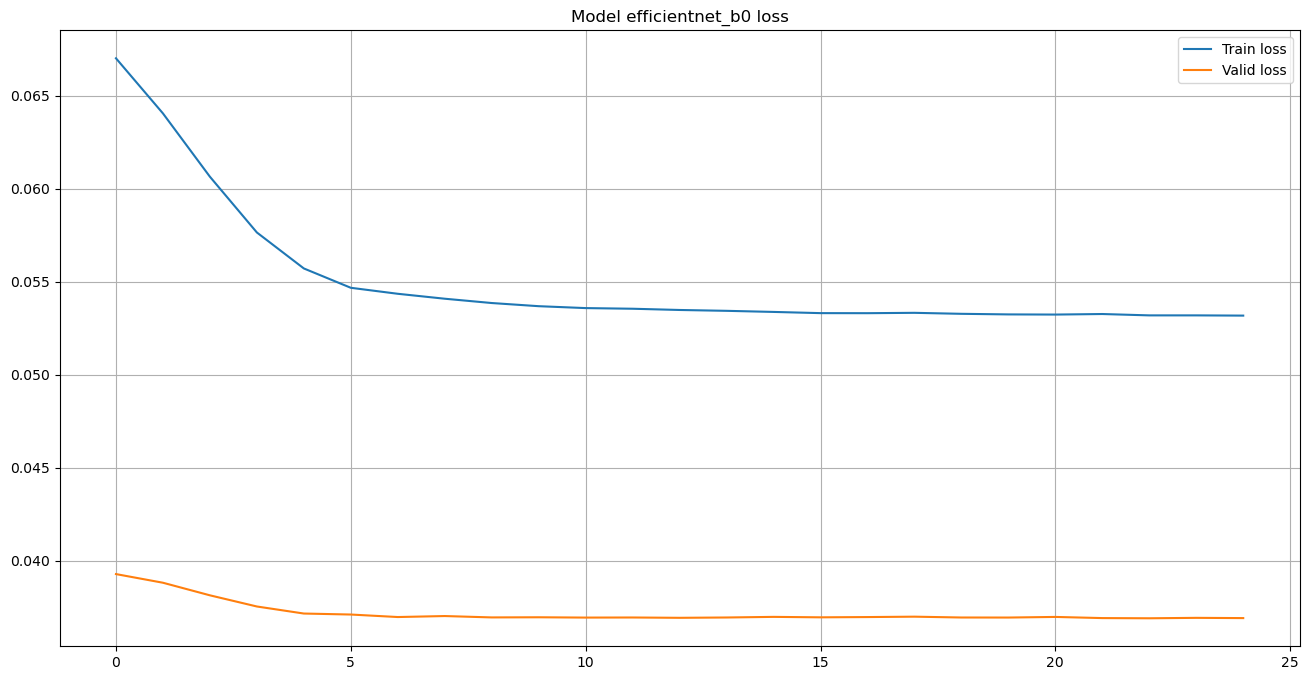

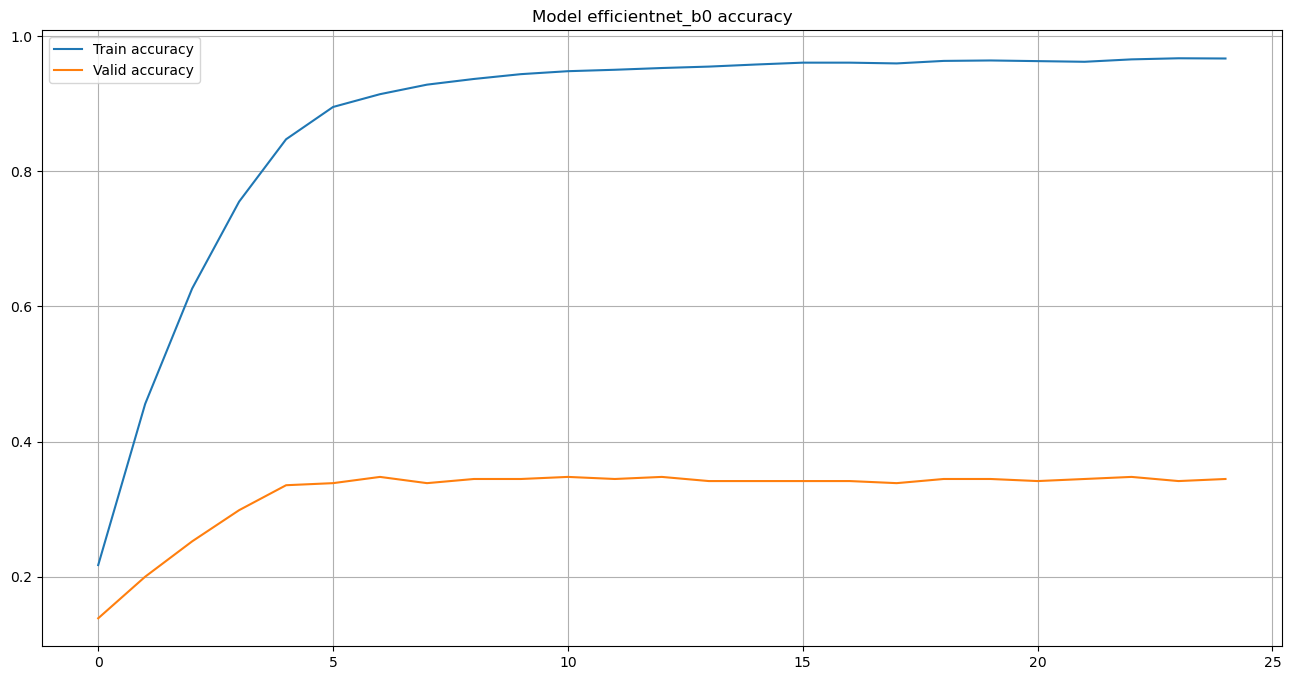

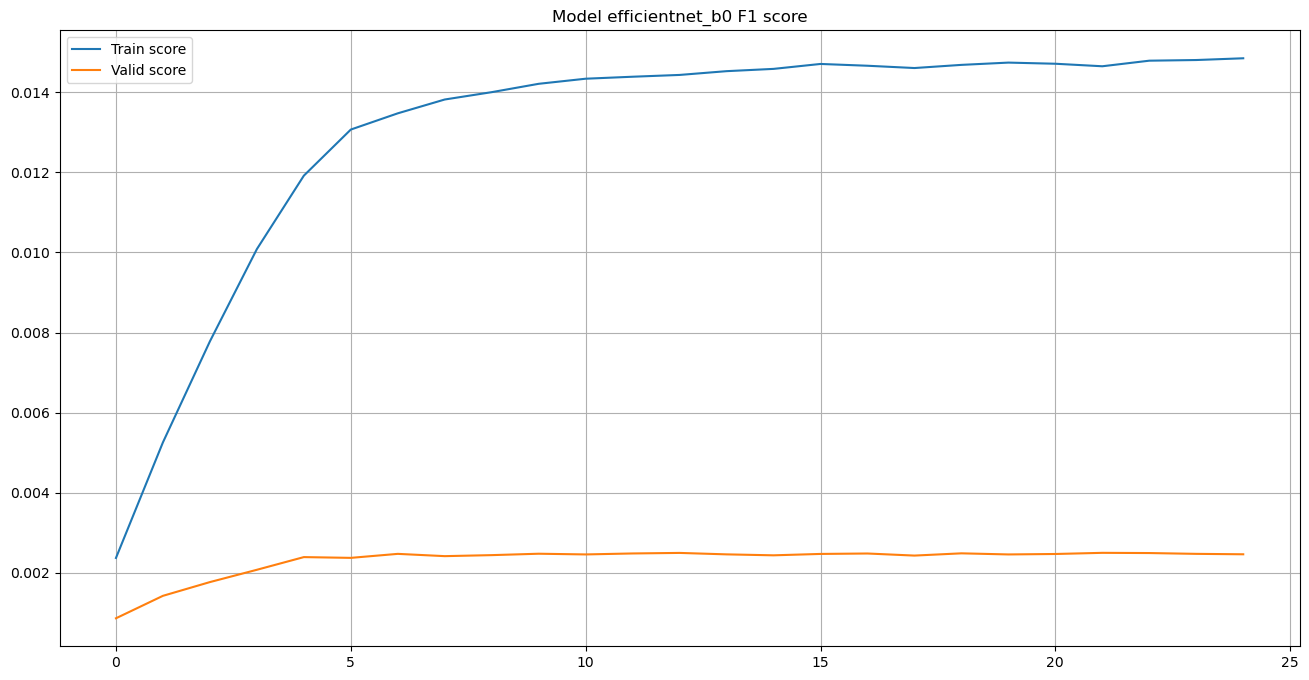

In [71]:
plot_stats(
    **history,
    title=f"Model {config.model_name}"
)

# 8. Result evaluation

In [72]:
model.eval()  # Set the model to evaluation mode
predictions = []

with torch.no_grad():
    for images, _ in test_dataloader:
        images = images.to(device)
        outputs = model(images)
        
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())

In [73]:
c_report = classification_report(test_dataset.labels, np.array(predictions), output_dict=True, zero_division=0)
c_report = pd.DataFrame(c_report).transpose()
c_report

,precision,recall,f1-score,support
0,1.000000,1.000000,1.000000,2.000000
1,1.000000,1.000000,1.000000,6.000000
2,0.750000,1.000000,0.857143,3.000000
3,1.000000,1.000000,1.000000,4.000000
4,1.000000,1.000000,1.000000,4.000000
...,...,...,...,...
73,0.000000,0.000000,0.000000,5.000000
74,0.000000,0.000000,0.000000,0.000000
accuracy,0.344615,0.344615,0.344615,0.344615
macro avg,0.306487,0.323259,0.313201,325.000000


In [74]:
c_report[c_report['precision'] > 0][:-3].mean()

precision    0.919460
recall       0.969778
f1-score     0.939604
support      4.680000
dtype: float64

In [79]:
accuracy_score(test_dataset.labels, np.array(predictions))

0.3446153846153846

In [77]:
test_dataset.labels

array([59, 39, 42,  6, 42, 19, 56, 66, 20, 27, 23, 70, 13, 11, 17, 21, 26,
       72, 62,  1, 31, 39, 28, 13, 37, 17, 26, 41,  0, 64, 52, 54, 68, 10,
       45, 23, 64, 72, 16, 50, 49, 33,  6,  4, 32, 33, 16, 11, 23, 48,  1,
       23,  1, 34, 66, 34, 29, 45,  8, 44, 58, 69, 57, 59, 63, 21, 56, 44,
       64, 71, 33, 55, 48, 60, 51, 46, 43,  3, 63, 12, 13, 41, 26,  4, 42,
       52, 37, 12,  1, 34, 13, 34, 54, 61, 26, 11,  3, 36, 33, 59, 46, 26,
       27, 26, 58,  1, 66, 67, 35,  9, 73, 30, 24, 62,  0, 17,  6, 26, 22,
       34, 32, 20, 48, 38, 21, 64,  5, 29, 40, 73, 44, 34, 50, 60, 73, 64,
       24, 43, 40, 73, 32, 38, 31, 28, 19, 21, 44,  9, 47, 54, 18, 62, 40,
       70, 11, 10, 20, 17, 15, 27, 36, 55, 61, 51, 12, 39,  5, 49, 22,  3,
       39, 53, 56, 31, 70, 27, 47,  5, 45,  7, 44, 17, 64, 49, 29, 60, 19,
       54, 37, 38, 10, 55, 54, 42, 46, 30, 63, 28, 15, 37,  8, 69, 10, 14,
       53, 11, 65, 18,  6, 63, 14, 27, 71, 34, 23, 18, 72,  5, 18, 10, 64,
       23, 54, 29, 12, 20

In [78]:
np.array(predictions)

array([60, 40, 43,  6, 10, 19, 57, 67, 20, 28, 23, 44, 13, 11, 17, 21, 27,
       73, 63,  1, 32, 69, 29, 13, 38, 17, 27, 42,  0, 65, 53, 55, 69, 10,
       46, 23, 65, 73, 16, 51, 50, 34,  6,  4, 33, 34, 16, 11, 23, 49,  1,
       23,  1, 35, 67, 35, 30, 46,  8, 45, 59, 70, 58, 60, 64, 21, 57,  2,
       65, 72, 34, 56, 49, 61, 52, 47, 44,  3, 64, 12, 13, 42, 27,  4, 43,
       53, 38, 12,  1, 35, 13, 35, 55, 62, 27, 11,  3, 37, 34, 60, 47,  8,
       28, 27, 59,  1, 67, 68, 36,  9, 74, 31, 24, 63,  0, 17,  6, 27, 22,
       35, 33, 20, 23, 39, 21, 65,  5, 30, 41, 74, 45, 45, 51, 61, 74, 65,
       24, 44, 20, 74, 33, 39, 32, 29, 19, 21, 45,  9, 48, 55, 18, 63, 41,
       71, 11, 10, 20, 17, 15, 28, 37, 56, 73, 52, 12, 40,  5, 16, 56,  3,
       40, 54, 57, 32, 71, 28, 48,  5, 46,  7, 45, 17, 65, 50, 30, 61, 19,
       55, 38, 39, 10, 56, 55, 43, 47, 31, 64, 29, 15, 38,  8, 70, 10, 14,
       54, 11, 66, 18, 37, 17, 14, 28, 72, 35, 23, 18, 73,  5, 18, 70, 65,
       23, 55, 30, 12, 20